<a href="https://colab.research.google.com/github/thalessac/rateio/blob/main/rateio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to run this script

###User inputs

First you'll need to provide:


1.   Invoice values: insert them in the forms you'll find on the cell right after this User Guide, as they appear on the invoice


*   `taxa_adm` (Taxa de administração)
*   `fetransp` (Repasse FETRANSPOR)
*   `desconto` (Total "Desconto ref. avisos de crédito" value)
*   `invoice_total_amount` (Total amount of the invoice - used to validate pro-rating calculation)


2.   Excel files:
when you execute the code, you'll be requested to upload the following files:


*   `exclusão.xlsx`: required columns ("matrícula", "funcionário", "total bilhete", "compõe aviso de crédito")
*   `itens_processados.xlsx`: required columns ("matrícula", "funcionário", "total bilhete")
*   `cadastrão.xlsx`: required columns ("cpf", "cc")

Note that file and tables headers MUST follow the above mentioned predefined names, otherwise the script will fail. There is no problem having more columns in your input files, since the mandatory ones are included. Header and file names are not case sensitive, so just make sure the spelling is correct.

You can also directly upload your files on 'Files' section in the left side bar of this Notebook.

### Running the script

Once you provided the invoice input values, press 'Execute cell' button below.
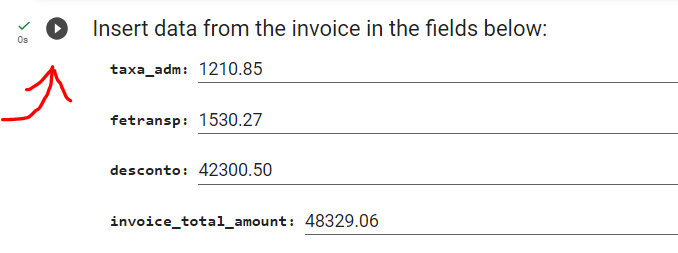

###Check the outputs
After a successful run, you'll see an output as follows, describing your input values and calculation steps of the script.

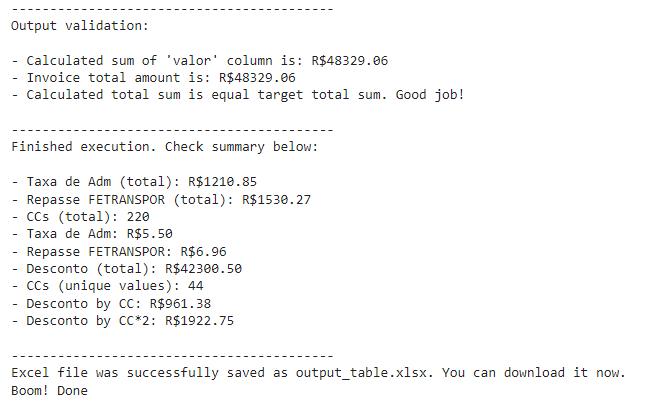

Finally, go to the 'Files' section on the left side bar and dowload the file named 'output_table.xlsx'

In [ ]:
from google.colab import files
import io
import os
import pandas as pd
import sys
import time
import warnings
try:
  import xlsxwriter
except:
  print("Installing dependencies...")
  !pip install XlsxWriter==3.1.2

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

def lower_case_file_names():
  for file in os.listdir():
      os.rename(file, file.lower())

def upload_excel_files(file: dict):
  lower_case_file_names()
  file_name, required_columns, file_description = file.values()
  print(f"\nReading '{file_name}': {file_description}")
  while True:
    try:
      data = pd.read_excel(file_name)
      print(f"- {file_name} already uploaded")
      break
    except FileNotFoundError:
      try:
        print(f"- Upload '{file_name}'")
        uploaded = files.upload()
        uploaded =  {k.lower(): v for k, v in uploaded.items()}
        data = pd.read_excel(io.BytesIO(uploaded[file_name]))
        lower_case_file_names()
        break
      except KeyError as e :
        print(f"ERROR: File name should be '{file_name}'. Try again")
    except Exception:
      print("Unexpected error")
      raise

  print(f"- Check a preview of {file_name} below:")
  display(data.head(5))

  data.columns = data.columns.str.strip().str.lower()
  missing_columns = set(required_columns) - set(data.columns)
  if len(missing_columns):
    print(f"Required columns missing in {file_name}: {missing_columns}")
    print("Check your input data and try again")
    !rm {file_name} #Remove file with errors
    raise ValueError("Missing columns in input file")

  return data

def read_user_inputs():
  #1. Values from Invoice
  #@markdown ### Insert data from the invoice in the fields below:
  taxa_adm = 1210.85 #@param {type:"number"}
  fetransp = 1530.27 #@param {type:"number"}
  desconto = 42300.50 #@param {type:"number"}
  invoice_total_amount = 43585.31 #@param {type:"number"}

  desconto = abs(desconto)

  #2. Upload Excel files
  tables = []
  files = [
      {"file_name": "itens_processados.xlsx",
       "required_columns": ["matrícula", "funcionário", "total bilhete"],
       "description": "'Relatório Assinatura e Itens Processados' from Ticket website"},
      {"file_name": "exclusão.xlsx",
       "required_columns": ["compõem aviso de crédito?", "matrícula", "funcionário", "total bilhete"],
       "description": "'Relatório Exclusão e aviso de credito' from Ticket website"},
      {"file_name": "cadastrão.xlsx",
       "required_columns": ["cpf", "cc"],
       "description": "File with cost center of each employer"},
  ]

  for file in files:
    data = upload_excel_files(file)
    tables.append(data)

  return taxa_adm, fetransp, desconto, invoice_total_amount, *tables

def print_execution_summary(
    taxa_adm: float,
    fetransp: float,
    desconto: float,
    n_ccs: int,
    n_ccs_unique: int):
  print("\n------------------------------------------")
  print("Finished execution. Check summary below:\n")
  print(f"- Taxa de Adm (total): R${taxa_adm:.2f}")
  print(f"- Repasse FETRANSPOR (total): R${fetransp:.2f}")
  print(f"- CCs (total): {n_ccs}")
  print(f"- Taxa de Adm: R${taxa_adm/n_ccs:.2f}")
  print(f"- Repasse FETRANSPOR: R${fetransp/n_ccs:.2f}")
  print(f"- Desconto (total): R${desconto:.2f}")
  print(f"- CCs (unique values): {n_ccs_unique}")
  print(f"- Desconto by CC: R${desconto/n_ccs_unique:.2f}")
  print(f"- Desconto by CC*2: R${2*desconto/n_ccs_unique:.2f}")

def validate_output(calculated_total_sum: float, invoice_total_amount: float):
  print("\n------------------------------------------")
  print("Output validation:\n")
  print(f"- Calculated sum of 'total bilhete' column is: R${calculated_total_sum:.2f}")
  print(f"- Invoice total amount is: R${invoice_total_amount:.2f}")
  if round(calculated_total_sum, 2) == round(invoice_total_amount, 2):
    print("- Calculated total sum is equal target total sum. Good job!")
  else:
    diff = abs(calculated_total_sum - invoice_total_amount)
    diff_percent = diff/invoice_total_amount
    print(f"- Calculated total sum differs in R${diff:.2f} ({100*diff_percent:.3f}%) from target total sum")
    if diff_percent > 0.01:
      print(("WARNING: Calculated total value differs in more than 1% from target value. Check your inputs and try again."))
      print("Resuming in 15s...")
      time.sleep(15)

def save_to_excel(
    file_name: str,
    df_final: pd.DataFrame,
    pivot_table_final: pd.DataFrame):
  print("\n------------------------------------------")
  if not file_name.endswith(".xlsx"):
    file_name += ".xlsx"
  writer = pd.ExcelWriter(file_name, engine="xlsxwriter")
  workbook  = writer.book
  df_final.to_excel(
      writer,
      sheet_name="Sheet1",
      startrow=0,
      startcol=0,
      header=True,
      index=False)
  pivot_table_final.to_excel(
      writer,
      sheet_name="Sheet1",
      startrow=0,
      startcol=6,
      header=True,
      index=False)

  #Currency formatting
  worksheet = writer.sheets["Sheet1"]
  currency_format = workbook.add_format()
  currency_format.set_num_format('R$#,##0.00')
  worksheet.set_column(2, 2, None, currency_format)
  worksheet.set_column(7, 7, None, currency_format)
  worksheet.autofit()
  writer.save()
  print(f"Excel file was successfully saved as {file_name}. You can download it now.")

def pivot_table_label(value, desconto_by_cc) -> str:
    if value < desconto_by_cc:
      return 'blue'
    elif value >= desconto_by_cc and value < 2*desconto_by_cc:
      return 'green'
    else:
      return 'purple'

def apply_label_value(
    label: str,
    total_bilhete: float,
    desconto_by_cc: float,
    desconto_by_purple_cc: float) -> float:
    if label == 'blue':
      return -abs(total_bilhete)
    elif label == 'green':
      return -abs(desconto_by_cc)
    elif label == 'purple':
      return -abs(desconto_by_purple_cc)

def create_rateio_df(itens_processados: pd.DataFrame, exclusao: pd.DataFrame, cadastrao: pd.DataFrame):
  cadastrao = cadastrao.rename(columns={"centro de resultado - código": "cc"})
  exclusao_filtered = exclusao.loc[exclusao["compõem aviso de crédito?"].str.lower() == "sim", ["matrícula", "funcionário", "total bilhete"]]
  df = pd.concat([itens_processados, exclusao_filtered])
  df = df.merge(cadastrao, left_on='matrícula', right_on='cpf', how='left')
  nulls = df.loc[pd.isnull(df['cc']), ["funcionário", "matrícula", "cc"]].drop_duplicates()
  if len(nulls):
    print("\nWARNING: CCs not found in 'Cadastrão'. Go to Workday to confirm if it is a new hire. \
    \nIf the CC is not in the 'Relatório de Contratações', Onboarding Team should be contacted as the owner of the information. \
    \nIf you confirm in Workday that any of the employees has already been terminated, look for CC in 'Cadastrão' report of the month before the termination.")
    print("Check missing CCs below:")
    display(nulls)
    return
  return(df[["funcionário", "cpf", "total bilhete", "cc"]])

def calculate_amount_by_cc(
    taxa_adm: float,
    fetransp: float,
    desconto: float,
    invoice_total_amount: float,
    df: pd.DataFrame) -> pd.DataFrame:

  #Apply values from invoice on rateio table

  n_ccs = df['cc'].count()
  n_ccs_unique = df['cc'].nunique()
  ccs_list = list(df['cc'])

  input_dict = {
      "Taxa de administração": taxa_adm,
      "Repasse FETRANSPOR": fetransp}

  df_aux=[]
  for k,v in input_dict.items():
    for cc in ccs_list:
      calc_dict = {"funcionário": k, "total bilhete": v/n_ccs, "cc": cc}
      df_aux.append(calc_dict)
  df_aux = pd.DataFrame.from_records(df_aux)
  df = pd.concat([df, df_aux])

  #Create pivot table and classify with labels

  pivot_table = pd.pivot_table(df, values='total bilhete', index='cc', aggfunc='sum')
  desconto_by_cc = desconto/n_ccs_unique
  pivot_table['label'] = pivot_table.apply(
      lambda row: pivot_table_label(row["total bilhete"],
                                    desconto_by_cc), axis=1)
  pivot_table = pivot_table.reset_index()
  label_counts = pivot_table['label'].value_counts()
  sum_of_blue_and_green = (
      pivot_table.loc[pivot_table.label == 'blue', 'total bilhete'].sum() +
      label_counts.get('green', 0)*desconto_by_cc)
  purple_total_discount = desconto - sum_of_blue_and_green
  desconto_by_purple_cc = purple_total_discount/label_counts.get('purple', 1)

  #Recalculate discount by CC based on labels rule

  pivot_table['total bilhete'] = pivot_table.apply(
      lambda row: apply_label_value(row.label,
                                    row["total bilhete"],
                                    desconto_by_cc,
                                    desconto_by_purple_cc), axis=1)
  pivot_table['funcionário'] = 'Desconto'
  pivot_table = pivot_table[['funcionário', 'total bilhete', 'cc']]

  #Final tables

  df_final = pd.concat([df, pivot_table]).reset_index(drop=True)
  df_final = df_final.rename(columns={"funcionário": "Funcionário", "cpf": "CPF", "total bilhete": "Total bilhete", "cc": "CC"})
  pivot_table_final = pd.pivot_table(df_final,
                                     values='Total bilhete',
                                     index='CC',
                                     aggfunc='sum')
  pivot_table_final = pivot_table_final.sort_values(by='CC').reset_index()

  validate_output(pivot_table_final['Total bilhete'].sum(), invoice_total_amount)
  print_execution_summary(taxa_adm, fetransp, desconto, n_ccs, n_ccs_unique)
  return df_final, pivot_table_final

def main():
  output_file_name = "output_table"
  (taxa_adm,
   fetransp,
   desconto,
   invoice_total_amount,
   itens_processados,
   exclusao,
   cadastrao) = read_user_inputs()
  df = create_rateio_df(itens_processados, exclusao, cadastrao)
  if df is not None:
    df_final, pivot_table_final = calculate_amount_by_cc(
        taxa_adm=taxa_adm,
        fetransp=fetransp,
        desconto=desconto,
        invoice_total_amount=invoice_total_amount,
        df=df)
    save_to_excel(output_file_name, df_final, pivot_table_final)
    print("Boom! Done")
  else:
    print("\nEnd of execution")

main()